# Support Vector Machines

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support, accuracy_score
from tqdm import tqdm

First, load in our dataset.

In [20]:
df = pd.read_csv("./data/nan_removed_cleaned_data.csv")
df.columns

Index(['budget', 'genres', 'id', 'imdb_id', 'original_title', 'overview',
       'popularity', 'poster_path', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'log_popularity', 'title_length', 'num_languages', 'num_genres',
       'imdb_rating', 'imdb_budget', 'imdb_revenue', 'budget_currency',
       'revenue_currency', 'converted_budget', 'converted_revenue',
       'combined_budget', 'combined_revenue'],
      dtype='object')

SVMs are a supervised learning process for binary classification. So let's classify our data on a binary variable.

Just as we did with Naive Bayes, we can attempt to classify whether our film will be a box-office flop or success.

But this time, we can use most the data available to us instead of just a classifier based on the text description of the movie.

Let's set up the data:

In [21]:
print(df.shape[0])

# First, convert our datetime objects to Unix timestamps
df['release_unix'] = pd.to_datetime(df['release_date'])
df['release_unix'] = df.release_unix.values.astype(np.int64) // 10 ** 9

# Next, only pick out any relevant columns
df = df[['runtime', 'vote_count', 'log_popularity', 'title_length', 'num_languages', 'num_genres', 'imdb_rating', 'combined_budget',
         'combined_revenue', 'release_unix']]

# Next, remove any missing data
df.dropna(inplace=True)

df.shape[0]

16012


13894

As shown, we only lost 2118 rows after removing missing data. We're left with 13894 rows of data!

We can use the same method as in Naive Bayes to create a new column that holds whether a film is a box office success or flop (binary).

In [22]:
def box_office_success(row):
    if row['combined_budget'] < row['combined_revenue']:
        return 1
    else:
        return 0

df['labels'] = df.apply(box_office_success, axis=1)

display(df.head(10))

display(df['labels'].value_counts())

,runtime,vote_count,log_popularity,title_length,num_languages,num_genres,imdb_rating,combined_budget,combined_revenue,release_unix,labels
0,80,21,1.209259,32,5,1,8.1,8.013003e+04,1871.0,1136073600,0
1,100,17305,4.680380,12,1,2,8.2,9.400000e+07,940986748.0,1054252800,1
2,122,10783,3.274462,15,1,1,8.4,1.500000e+07,356296601.0,937353600,1
3,141,1506,2.635121,18,1,2,7.9,1.280000e+07,40046516.0,962323200,1
4,87,225,2.127994,8,2,3,5.3,5.302639e+06,6593579.0,1127865600,1
5,126,9451,3.880470,17,3,5,7.6,9.150000e+07,263920180.0,862531200,1
6,106,398,2.471653,18,1,2,7.4,2.353900e+06,11040927.0,1046995200,1
7,91,88,2.077690,18,1,1,7.6,5.000000e+04,10233.0,-111974400,0
8,143,18370,4.407950,54,1,3,8.1,1.400000e+08,654637619.5,1057708800,1
9,111,15437,3.506308,17,3,2,8.2,3.000000e+07,180906076.0,1065744000,1


0    11684
1     2210
Name: labels, dtype: int64

Cool! As we can see, there are 2210 box office successes, and 11684 flops. Although we have a data imbalance, we can still apply SVM to our problem.

We'll want to keep the same proportion of class values in our training and testing set. Let's split our data:

In [23]:
# First, separate class labels
df_success = df[df['labels'] == 1]
df_fail = df[df['labels'] == 0]

# Next, just separate into predictors and response
x_success = df_success.drop('labels', axis=1)
y_success = df_success['labels']
x_fail = df_fail.drop('labels', axis=1)
y_fail = df_fail['labels']

# Next, take out specific class labels
x_success_train, x_success_test, y_success_train, y_success_test = train_test_split(x_success, y_success, test_size=0.2, random_state=1600)
x_fail_train, x_fail_test, y_fail_train, y_fail_test = train_test_split(x_fail, y_fail, test_size=0.2, random_state=1600)

# Concatenate everything
x_train = pd.concat([x_success_train, x_fail_train])
x_test = pd.concat([x_success_test, x_fail_test])
y_train = pd.concat([y_success_train, y_fail_train])
y_test = pd.concat([y_success_test, y_fail_test])

# # And shuffle
# x_train = x_train.sample(frac=1, random_state=1)
# x_test = x_test.sample(frac=1, random_state=1)
# y_train = y_train.sample(frac=1, random_state=1612)
# y_test = y_test.sample(frac=1, random_state=1612)

Great, now we have our separated data!

Let's run SVM on this:

100%|██████████| 100/100 [21:14<00:00, 12.74s/it]


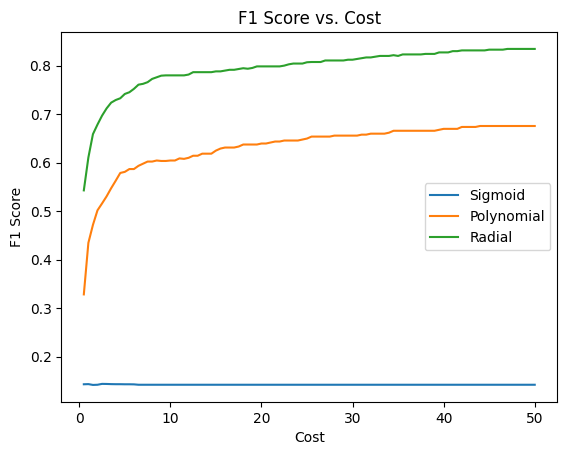

Best cost for sigmoid kernel: 2.5, F1 = 0.14383561643835616
Best cost for polynomial kernel: 44.0, F1 = 0.6755162241887906
Best cost for radial kernel: 47.0, F1 = 0.834419817470665


In [24]:
# Best costs for each kernel type
sigmoid_best_c = -1
sigmoid_best_f1 = -1
poly_best_c = -1
poly_best_f1 = -1
radial_best_c = -1
radial_best_f1 = -1

# Lists of f1 scores
sigmoid_f1s = []
poly_f1s = []
radial_f1s = []

# Range of costs to iterate over
costs = np.arange(0.5, 50.5, 0.5)

# Loop through a bunch of costs to determine the best one for each kernel
for cost in tqdm(costs):
    # Set up the SVMs
    SVM_sigmoid = SVC(C=cost, kernel='sigmoid')
    SVM_poly = SVC(C=cost, kernel='poly')
    SVM_radial = SVC(C=cost, kernel='rbf')

    # Fit each to the train data
    SVM_sigmoid.fit(x_train, y_train)
    SVM_poly.fit(x_train, y_train)
    SVM_radial.fit(x_train, y_train)

    # Predict each on the test data
    pred_sigmoid = SVM_sigmoid.predict(x_test)
    pred_poly = SVM_poly.predict(x_test)
    pred_radial = SVM_radial.predict(x_test)

    # Calculate the best F1 for sigmoid
    sigmoid_f1 = f1_score(y_test, pred_sigmoid)
    if sigmoid_f1 > sigmoid_best_f1:
        sigmoid_best_c = cost
        sigmoid_best_f1 = sigmoid_f1

    # Calculate the best F1 for poly
    poly_f1 = f1_score(y_test, pred_poly)
    if poly_f1 > poly_best_f1:
        poly_best_c = cost
        poly_best_f1 = poly_f1

    # Calculate the best F1 for radial
    radial_f1 = f1_score(y_test, pred_radial)
    if radial_f1 > radial_best_f1:
        radial_best_c = cost
        radial_best_f1 = radial_f1
    
    # Append to arrays
    sigmoid_f1s.append(sigmoid_f1)
    poly_f1s.append(poly_f1)
    radial_f1s.append(radial_f1)
    
plt.figure()
plt.plot(costs, sigmoid_f1s, label='Sigmoid')
plt.plot(costs, poly_f1s, label='Polynomial')
plt.plot(costs, radial_f1s, label='Radial')
plt.legend()
plt.xlabel('Cost')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Cost')
plt.savefig('./imgs/svm_ims/cost_comparison.png')
plt.show()


print(f"Best cost for sigmoid kernel: {sigmoid_best_c}, F1 = {sigmoid_best_f1}")
print(f"Best cost for polynomial kernel: {poly_best_c}, F1 = {poly_best_f1}")
print(f"Best cost for radial kernel: {radial_best_c}, F1 = {radial_best_f1}")

Great! Now we have (roughly) the best cost for each kernel. We can run the SVM on these specific models to evaluate our performance.

Sigmoid Stats:
Accuracy = 0.7301
Average Precision = 0.4918
Average Recall = 0.4919
Averagge F1 Score = 0.4918
Support = [2337  442]

Polynomial Stats:
Accuracy = 0.9208
Average Precision = 0.9433
Average Recall = 0.7576
Average F1 Score = 0.8152
Support = [2337  442]

Radial Stats:
Accuracy = 0.9543
Average Precision = 0.9675
Average Recall = 0.8609
Average F1 Score = 0.9040
Support = [2337  442]


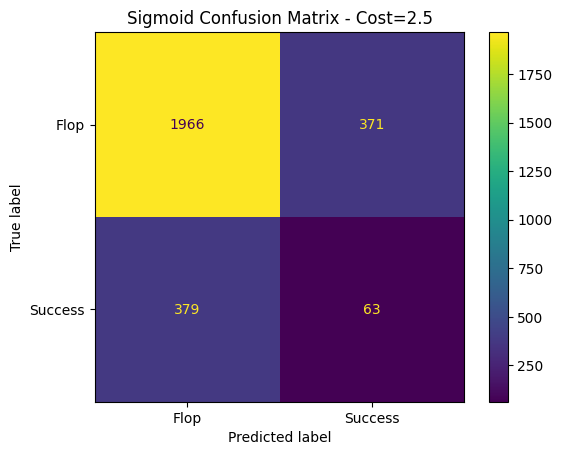

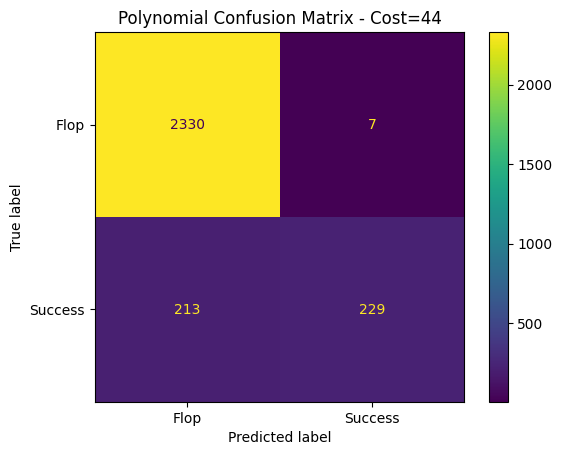

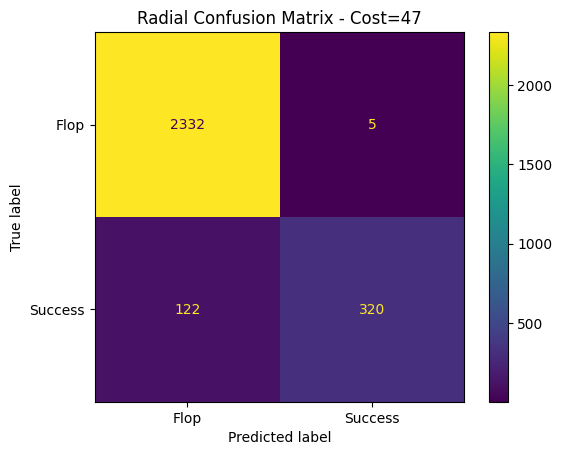

In [30]:
# Set up the SVMs
SVM_sigmoid = SVC(C=2.5, kernel='sigmoid')
SVM_poly = SVC(C=44, kernel='poly')
SVM_radial = SVC(C=47, kernel='rbf')

# Fit each to the train data
SVM_sigmoid.fit(x_train, y_train)
SVM_poly.fit(x_train, y_train)
SVM_radial.fit(x_train, y_train)

# Predict each on the test data
pred_sigmoid = SVM_sigmoid.predict(x_test)
pred_poly = SVM_poly.predict(x_test)
pred_radial = SVM_radial.predict(x_test)

# Create confusion matrices
matrix_sigmoid = confusion_matrix(y_test, pred_sigmoid)
matrix_poly = confusion_matrix(y_test, pred_poly)
matrix_radial = confusion_matrix(y_test, pred_radial)

# Display conf. matrices
# Also print info statistics about model performance
disp = ConfusionMatrixDisplay(matrix_sigmoid, display_labels=['Flop', 'Success'])
disp.plot()
plt.title('Sigmoid Confusion Matrix - Cost=2.5')
plt.savefig('./imgs/svm_ims/confusion_sigmoid.png')

print("Sigmoid Stats:")
sigmoid_prec, sigmoid_recall, sigmoid_f1, sigmoid_support = precision_recall_fscore_support(y_test, pred_sigmoid)
sigmoid_acc = accuracy_score(y_test, pred_sigmoid)
print(f"Accuracy = {sigmoid_acc:.4f}")
print(f"Average Precision = {np.mean(sigmoid_prec):.4f}")
print(f"Average Recall = {np.mean(sigmoid_recall):.4f}")
print(f"Averagge F1 Score = {np.mean(sigmoid_f1):.4f}")
print(f"Support = {sigmoid_support}\n")

disp = ConfusionMatrixDisplay(matrix_poly, display_labels=['Flop', 'Success'])
disp.plot()
plt.title('Polynomial Confusion Matrix - Cost=44')
plt.savefig(f'./imgs/svm_ims/confusion_poly.png')

print("Polynomial Stats:")
poly_prec, poly_recall, poly_f1, poly_support = precision_recall_fscore_support(y_test, pred_poly)
poly_acc = accuracy_score(y_test, pred_poly)
print(f"Accuracy = {poly_acc:.4f}")
print(f"Average Precision = {np.mean(poly_prec):.4f}")
print(f"Average Recall = {np.mean(poly_recall):.4f}")
print(f"Average F1 Score = {np.mean(poly_f1):.4f}")
print(f"Support = {poly_support}\n")

disp = ConfusionMatrixDisplay(matrix_radial, display_labels=['Flop', 'Success'])
disp.plot()
plt.title('Radial Confusion Matrix - Cost=47')
plt.savefig(f'./imgs/svm_ims/confusion_radial.png')

print("Radial Stats:")
radial_prec, radial_recall, radial_f1, radial_support = precision_recall_fscore_support(y_test, pred_radial)
radial_acc = accuracy_score(y_test, pred_radial)
print(f"Accuracy = {radial_acc:.4f}")
print(f"Average Precision = {np.mean(radial_prec):.4f}")
print(f"Average Recall = {np.mean(radial_recall):.4f}")
print(f"Average F1 Score = {np.mean(radial_f1):.4f}")
print(f"Support = {radial_support}")

As shown above, our Radial kernel is the most effective across **all of the** statistics, as also visible in the confusion matrix when compared to the others.

Going back to our Naive Bayes model from earlier, both the polynomial **and** radial kernel SVM models perform significantly better. This is not very surprising, since they are fed more data and are not restricted only to a text description of the film.